In [140]:
import geopandas as gpd

In [141]:
np.random.seed(360)  

In [142]:
import zipfile 
import os
zip_path = 'mrds-trim.zip' 
extract_to = 'data'
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref: zip_ref.extractall(extract_to)

First I will find the names of the files I unzipped so that I can read in the shape file. Then I will view a few basic features of my data to ensure that I understand my variables.

In [143]:

for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(os.path.join(root, file))

data/mrds-trim.shp
data/mrds-trim.shx
data/mrds.met
data/mrds-trim.dbf
data/mrds-trim.prj
data/mrds-trim.lyr


In [144]:
minerals = gpd.read_file("data/mrds-trim.shp")

In [145]:
print(minerals.shape)

(304632, 6)


In [146]:
print(minerals.columns)

Index(['DEP_ID', 'SITE_NAME', 'DEV_STAT', 'URL', 'CODE_LIST', 'geometry'], dtype='object')


In [147]:
print(minerals.head())

     DEP_ID            SITE_NAME    DEV_STAT  \
0  10000001     Lookout Prospect  Occurrence   
1  10000002  Lucky Find Prospect  Occurrence   
2  10000003  Mccullough Prospect  Occurrence   
3  10000004      Lucky Jim Claim  Occurrence   
4  10000005   Matilda Occurrence  Occurrence   

                                                 URL CODE_LIST  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU AU AG   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     CU AU   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU ZN AU   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU PB CU   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        AU   

                      geometry  
0  POINT (-132.14344 55.05612)  
1  POINT (-132.68514 55.52751)  
2  POINT (-132.99906 55.97751)  
3  POINT (-132.68653 55.52195)  
4  POINT (-132.05233 55.14556)  


As a preliminary investigation of what other minerals are contained in sites where lithium is present(to check for consistency with the geochemical analysis found in the literature review), we temporarily filter the data for lithium-containing mines. 

In [148]:

filtered_minerals = minerals[minerals['CODE_LIST'].str.contains('LI', na=False)]

In [149]:
print(filtered_minerals.shape)

(566, 6)


In [150]:
print(filtered_minerals.head())

        DEP_ID                SITE_NAME       DEV_STAT  \
4108  10004123             La Teresaida     Occurrence   
4156  10004198                   Ipizca     Occurrence   
4157  10004199  Salar Del Hombre Muerto     Occurrence   
4159  10004201         Reflejos Del Mar     Occurrence   
4165  10004207              Victor Hugo  Past Producer   

                                                    URL  \
4108  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4156  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4157  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4159  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4165  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   

                   CODE_LIST                     geometry  
4108       LI QTZ FLD MIC NB  POINT (-65.83271 -32.66411)  
4156                   LI BE  POINT (-65.54107 -28.72578)  
4157            LI K B CS RB  POINT (-66.99944 -25.24749)  
4159                   LI BE   POINT (-65.4494 -28.44745

We also filter mines that do not contain lithium to see which minerals are most commonly found in those locations (again, to confirm the applicability of the literature review geochemical analysis to our own dataset

In [151]:

no_lithium_minerals = minerals[~minerals['CODE_LIST'].str.contains('LI', na=False)]

In [152]:
print(no_lithium_minerals.shape)

(304066, 6)


In [153]:
print(no_lithium_minerals.head())

     DEP_ID            SITE_NAME    DEV_STAT  \
0  10000001     Lookout Prospect  Occurrence   
1  10000002  Lucky Find Prospect  Occurrence   
2  10000003  Mccullough Prospect  Occurrence   
3  10000004      Lucky Jim Claim  Occurrence   
4  10000005   Matilda Occurrence  Occurrence   

                                                 URL CODE_LIST  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU AU AG   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     CU AU   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU ZN AU   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU PB CU   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        AU   

                      geometry  
0  POINT (-132.14344 55.05612)  
1  POINT (-132.68514 55.52751)  
2  POINT (-132.99906 55.97751)  
3  POINT (-132.68653 55.52195)  
4  POINT (-132.05233 55.14556)  


We want to restrict our training data to North Carolina so we first need to check that our analysis will be feasible. To do this, we want to know if lithium-containing mines are in proximity to non-lithium-containing mines. We first subset for a North Carolina bounding box and then convert to an NC EPSG code. We remove processing plants and abandoned sand and gravel pits for reasons justified in the final report.

In [154]:

min_lat, max_lat = 33.8333, 36.5833
min_lon, max_lon = -84.3167, -75.4667


minerals['longitude'] = minerals.geometry.x
minerals['latitude'] = minerals.geometry.y


minerals_nc = minerals[
    (minerals['latitude'] >= min_lat) & (minerals['latitude'] <= max_lat) &
    (minerals['longitude'] >= min_lon) & (minerals['longitude'] <= max_lon)
]

import geopandas as gpd


nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"]



minerals = minerals.to_crs(nc.crs)


minerals_nc = minerals[minerals.within(nc.geometry.iloc[0])]

print(f"Original count: {len(minerals)}")
print(f"Points strictly INSIDE NC: {len(minerals_nc)}")
print(minerals_nc.head())

Original count: 304632
Points strictly INSIDE NC: 5184
         DEP_ID             SITE_NAME    DEV_STAT  \
8293   10008424             Boy Scout  Occurrence   
8294   10008425  Robert Miller's Farm  Occurrence   
8913   10009176         Randolph Mine    Producer   
8914   10009177            Deake Mine    Producer   
23804  10024735         Bessemer City    Prospect   

                                                     URL      CODE_LIST  \
8293   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...       MO CU AG   
8294   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...             MO   
8913   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  NB TA MIC FLD   
8914   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  NB TA MIC FLD   
23804  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  LI FLD MIC BE   

                         geometry  longitude  latitude  
8293   POINT (-77.87999 36.25841)  -77.87999  36.25841  
8294   POINT (-82.26652 36.05009)  -82.26652  36.05009  
8913

In [155]:

minerals_nc_projected = minerals_nc.to_crs(epsg=32119)


minerals_nc_projected = minerals_nc_projected[
    ~minerals_nc_projected['DEV_STAT'].isin(['Unknown', 'Plant']) &
    ~(minerals_nc_projected['CODE_LIST'] == 'SDG')
]

As an example to make sure our analysis works, we check distance between one particular mine that contains lithium and surrounding mines that do not contain lithium. If we are able to calculate distances, then we have early indication that we can proceed with our project and that our analysis will be feasible.

In [156]:

li_mines = minerals_nc_projected[minerals_nc_projected['CODE_LIST'].str.contains('LI', na=False)]
print(li_mines.iloc[0])

DEP_ID                                                10024735
SITE_NAME                                        Bessemer City
DEV_STAT                                              Prospect
URL          https://mrdata.usgs.gov/mrds/show-mrds.php?dep...
CODE_LIST                                        LI FLD MIC BE
geometry         POINT (411158.29533077776 177832.56568582306)
longitude                                            -81.18315
latitude                                              35.33343
Name: 23804, dtype: object


In [157]:

non_li_mines = minerals_nc_projected[~minerals_nc_projected['CODE_LIST'].str.contains('LI', na=False)]

In [158]:
non_li_mines.shape

(4097, 8)

In [159]:
bessemer_city_geom = minerals_nc_projected.loc[23804, 'geometry']

In [160]:
print(bessemer_city_geom)

POINT (411158.29533077776 177832.56568582306)


In [161]:
non_li_mines = non_li_mines.copy()
non_li_mines['distance_to_bessemer'] = non_li_mines.geometry.distance(bessemer_city_geom)

In [162]:

print(non_li_mines[['DEP_ID', 'SITE_NAME', 'distance_to_bessemer', "CODE_LIST", "DEV_STAT"    ]].sort_values('distance_to_bessemer').head())

          DEP_ID                            SITE_NAME  distance_to_bessemer  \
77168   10079365          Unnamed Stone Quarry Fk-045           5656.124332   
289697  10297157                          Froneberger           6736.869397   
76774   10078901    Spencer Mountain Quartzite Quarry           7203.166211   
77009   10079138                    Unnamed Gold Mine           7338.096643   
76772   10078899  Spencer Mountain Kyanite Occurrence           7403.812414   

       CODE_LIST       DEV_STAT  
77168        STN       Producer  
289697        MN       Prospect  
76774        STN  Past Producer  
77009         AU  Past Producer  
76772    QTZ KYN     Occurrence  


These are close mines which means that lithium mines are near mines that do not contain lithium, so we can proceed!

# KMEANS on North Carolina Mines

Now we run KMeans to form centroids on our training data from North Carolina. This will allow us to determine the centroids on which we will focus our analysis. First we try 20 clusters, then 15 based on the visual appearance of our data.

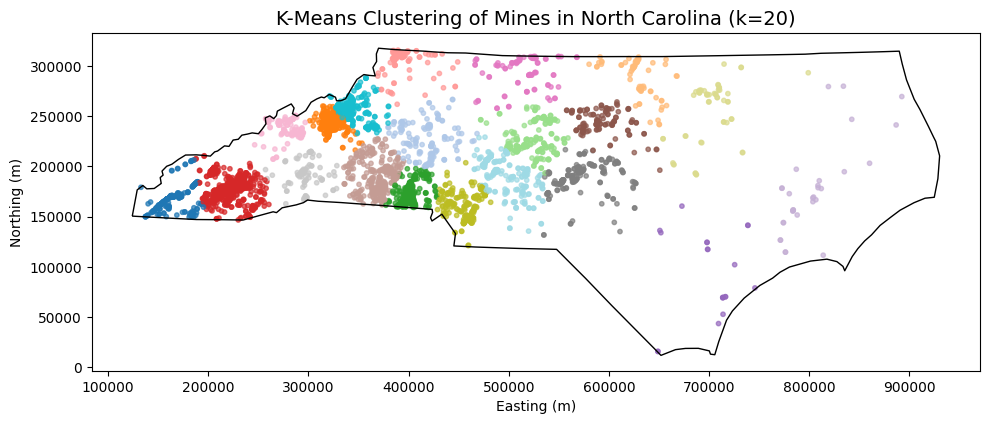

In [163]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_nc_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 20  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)


nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"].to_crs(gdf.crs)


fig, ax = plt.subplots(figsize=(10, 8))

nc.boundary.plot(ax=ax, color='black', linewidth=1)


gdf.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7, legend=False)

ax.set_title(f"K-Means Clustering of Mines in North Carolina (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

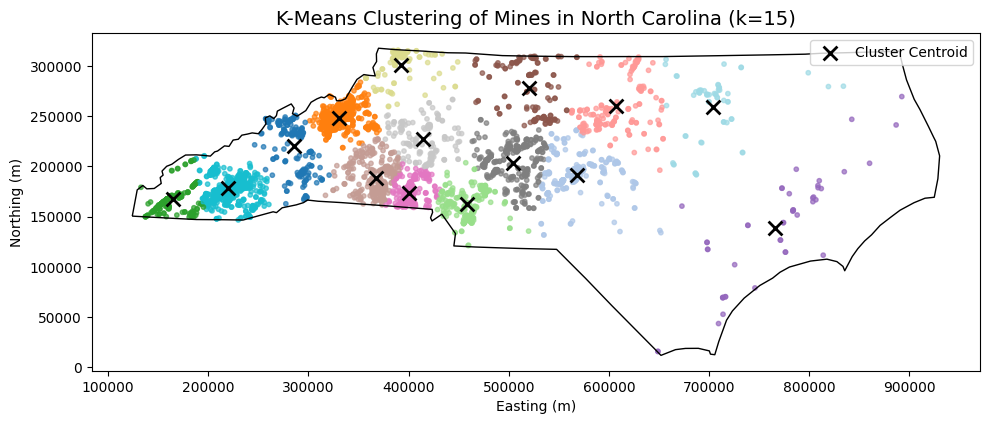

In [164]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_nc_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 15  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)


nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"].to_crs(gdf.crs)


fig, ax = plt.subplots(figsize=(10, 8))


nc.boundary.plot(ax=ax, color='black', linewidth=1)


gdf.plot(ax=ax, column='cluster', cmap='tab20',
         markersize=10, alpha=0.7, legend=False)


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker='x', s=100, c='black', linewidths=2,
            label='Cluster Centroid')


plt.legend()

ax.set_title(f"K-Means Clustering of Mines in North Carolina (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

Now we add the cluster assignments back into the original dataset and then we examine the mineral makeup.

In [165]:

minerals_nc_projected['cluster'] = gdf['cluster'].values


print(minerals_nc_projected[['DEP_ID', 'SITE_NAME', 'cluster', 'CODE_LIST']].head())

         DEP_ID             SITE_NAME  cluster      CODE_LIST
8293   10008424             Boy Scout       14       MO CU AG
8294   10008425  Robert Miller's Farm        2             MO
8913   10009176         Randolph Mine        2  NB TA MIC FLD
8914   10009177            Deake Mine        2  NB TA MIC FLD
23804  10024735         Bessemer City        9  LI FLD MIC BE


In [166]:

cluster_targets_nc = (
    minerals_nc_projected
    .assign(LI_present=lambda df: df['CODE_LIST'].str.contains('LI', na=False).astype(int))
    .groupby('cluster')['LI_present']
    .max()
    .reset_index()
)

print(cluster_targets_nc)

    cluster  LI_present
0         0           0
1         1           0
2         2           0
3         3           0
4         4           0
5         5           0
6         6           0
7         7           0
8         8           0
9         9           1
10       10           0
11       11           0
12       12           0
13       13           0
14       14           0


In [167]:
import pandas as pd


df = minerals_nc_projected[['cluster', 'CODE_LIST', 'geometry']].copy()


df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']


df['elements'] = df['CODE_LIST'].str.split(r'\s+')


df_exploded = df.explode('elements')


df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']


element_freq = (
    df_exploded
    .groupby(['cluster', 'elements'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
)

print(element_freq.head(30)) 


freq_table = (
    element_freq
    .pivot(index='elements', columns='cluster', values='count')
    .fillna(0)
    .astype(int)
)

print(freq_table.head(20))  

top5_elements_per_cluster = (
    element_freq
    .groupby('cluster')
    .head(5)
    .reset_index(drop=True)
)

print(top5_elements_per_cluster)

top_elements_summary = (
    top5_elements_per_cluster
    .groupby('elements')['count']
    .sum()
    .reset_index()
    .sort_values('count', ascending=False)
)

print(top_elements_summary)

    cluster elements  count
41        0      TLC     47
18        0      FLD     25
43        0        W     23
16        0       FE     22
36        0    STN_C     21
40        0     TI_M     14
23        0      MIC     13
13        0       CR     12
24        0       MN     12
15        0        F     11
6         0       BA     10
45        0       ZR      9
8         0      CLY      8
14        0       CU      8
21        0      MBL      8
29        0       PB      8
27        0      OLV      7
19        0      GRT      5
26        0       NI      5
33        0      REE      5
34        0        S      5
39        0       TH      5
42        0      VRM      4
1         0       AG      3
4         0      ASB      3
5         0       AU      3
25        0       MO      3
37        0    STN_D      3
2         0       AL      2
9         0   CLY_BK      2
cluster   0   1   2   3    4   5   6   7   8   9    10  11  12  13  14
elements                                                     

# Distance metrics and density measurements

Based on geochemical research articles cited in our analysis paper, the minerals which serve as the best indicators of lithium presence are: tin, quartz, mica, feldspar, beryllium, and cesium. Using that, we want to calculate the density of each of these minerals within a certain radius of the centroid of each cluster. We will use a radius of 10 miles away from the centroid. Then we count the number of that specific mineral in that radius and the total number of minerals in that radius and take the proportion as the density of that mineral. That will serve as a predictor for the presence of lithium in our model. Recall that we are predicting the overall probability that lithium is present in the cluster using these densities as variables.

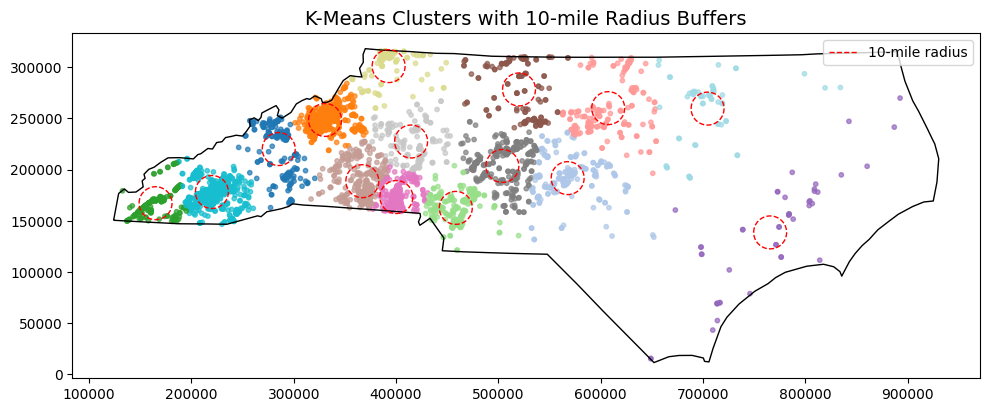

In [168]:

radius_meters = 10 * 1609.34



from shapely.geometry import Point
centroid_points = [Point(xy) for xy in centers]  
centroids_gdf = gpd.GeoDataFrame({'cluster': range(len(centers))},
                                 geometry=centroid_points,
                                 crs=minerals_nc_projected.crs)


buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


fig, ax = plt.subplots(figsize=(10, 8))

nc.boundary.plot(ax=ax, color='black', linewidth=1)
buffers_gdf.boundary.plot(ax=ax, color='red', linestyle='--', linewidth=1, label='10-mile radius')
minerals_nc_projected.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7)

plt.legend()
ax.set_title("K-Means Clusters with 10-mile Radius Buffers", fontsize=14)
plt.tight_layout()
plt.show()

In [169]:

df = minerals_nc_projected[['cluster', 'CODE_LIST', 'geometry']].copy()
df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']
df['elements'] = df['CODE_LIST'].str.split(r'\s+')

df_exploded = df.explode('elements')
df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']
df_exploded = gpd.GeoDataFrame(df_exploded, geometry='geometry', crs=minerals_nc_projected.crs)


radius_meters = 10 * 1609.34
centroid_points = [Point(xy) for xy in centers]  
centroids_gdf = gpd.GeoDataFrame({'cluster': range(len(centers))},
                                 geometry=centroid_points,
                                 crs=minerals_nc_projected.crs)
buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')

target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']
filtered = joined[joined['elements'].isin(target_elements)]


counts = (filtered.groupby(['cluster_right', 'elements'])
                    .size()
                    .reset_index(name='count'))

print(counts)

    cluster_right elements  count
0               0      FLD     13
1               0      MIC      4
2               1      MIC      5
3               2       BE      1
4               2      FLD    513
5               2      MIC    794
6               2      QTZ     11
7               4      QTZ      1
8               8       BE      3
9               8      FLD      1
10              8      MIC     99
11              8      QTZ      1
12              9       BE      9
13              9       CS      1
14              9      FLD     63
15              9      MIC     58
16              9      QTZ     54
17              9       SN    103
18             11       BE      2
19             11      FLD      1
20             11      MIC     16
21             13      MIC    207


In [170]:

totals = (
    joined.groupby('cluster_right')
          .size()
          .reset_index(name='total_number_of_minerals')
)


counts_with_totals = counts.merge(totals, on='cluster_right')


counts_with_totals['proportion'] = counts_with_totals['count'] / counts_with_totals['total_number_of_minerals']

print(counts_with_totals)

    cluster_right elements  count  total_number_of_minerals  proportion
0               0      FLD     13                        77    0.168831
1               0      MIC      4                        77    0.051948
2               1      MIC      5                        98    0.051020
3               2       BE      1                      1474    0.000678
4               2      FLD    513                      1474    0.348033
5               2      MIC    794                      1474    0.538670
6               2      QTZ     11                      1474    0.007463
7               4      QTZ      1                       141    0.007092
8               8       BE      3                       128    0.023438
9               8      FLD      1                       128    0.007812
10              8      MIC     99                       128    0.773438
11              8      QTZ      1                       128    0.007812
12              9       BE      9                       534    0

Now we build our logistic regression model using those proportions as predictors, along with another predictor that is the number of mining deposits/sites in the cluster.

In [171]:
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


all_clusters_idx = pd.Index(buffers_gdf['cluster'], name='cluster_right')


target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']

element_counts = (
    joined[joined['elements'].isin(target_elements)]
    .groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='elements', values='count')
)
element_counts_full = element_counts.reindex(all_clusters_idx).fillna(0)

totals_full = (
    joined.groupby('cluster_right')
    .size()
    .reindex(all_clusters_idx)
    .fillna(0)
    .rename('total')
)


element_props = element_counts_full.div(totals_full, axis=0).fillna(0)


dev_counts = (
    minerals_nc_projected
    .sjoin(buffers_gdf, how='inner', predicate='within')
    .groupby(['cluster_right', 'DEV_STAT'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='DEV_STAT', values='count')
)
dev_counts_full = dev_counts.reindex(all_clusters_idx).fillna(0)


dev_counts_full['num_places'] = dev_counts_full.sum(axis=1)


X = element_props.merge(dev_counts_full, left_index=True, right_index=True)


drop_cols = ['Past Producer', 'Producer', 'Occurrence', 'Prospect']
X = X.drop(columns=[c for c in drop_cols if c in X.columns])


y = (
    cluster_targets_nc.set_index('cluster')
    .reindex(all_clusters_idx)['LI_present']
    .fillna(0)
    .astype(int)
)


logreg = LogisticRegression(
    max_iter=1000,
    random_state=0,
    class_weight='balanced'
)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', logreg)
])


pipe.fit(X, y)


coef = pd.Series(pipe.named_steps['logreg'].coef_[0], index=X.columns)
print("Logistic regression coefficients (sorted):")
print(coef.sort_values(ascending=False))
print("\nIntercept:", pipe.named_steps['logreg'].intercept_[0])


y_pred = pipe.predict(X)
y_prob = pipe.predict_proba(X)[:, 1]

results = pd.DataFrame({
    'LI_present': y,
    'predicted_class': y_pred,
    'predicted_prob': y_prob
}, index=X.index)

print("\nClassification report:")
print(classification_report(y, y_pred, digits=3))
print("\nCluster-level predictions:")
print(results)


Logistic regression coefficients (sorted):
SN            0.626651
CS            0.626651
QTZ           0.619426
BE            0.119516
FLD           0.100791
num_places    0.054059
MIC          -0.057033
dtype: float64

Intercept: -3.35265138046675

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        14
           1      1.000     1.000     1.000         1

    accuracy                          1.000        15
   macro avg      1.000     1.000     1.000        15
weighted avg      1.000     1.000     1.000        15


Cluster-level predictions:
               LI_present  predicted_class  predicted_prob
cluster_right                                             
0                       0                0        0.021631
1                       0                0        0.018327
2                       0                0        0.034594
3                       0                0        0.018673
4                 

Now we augment the data to overrepresent lithium-containing clusters so that we have more balanced data and our model is no longer memorizing. Also, we use gradient bagging and boosting, and we use cross validation and standardization. 

In [172]:
import numpy as np
import pandas as pd

def augment_with_noise(X, num_augmented, mean=0.0, std=0.05):
    augmented = []
    for _ in range(num_augmented):
        noise = np.random.normal(mean, std, X.shape)
        augmented.append(X + noise)
    return pd.DataFrame(np.vstack(augmented), columns=X.columns)


X_li = X[y == 1]
X_non_li = X[y == 0]


n_li = len(X_li)
n_non_li = len(X_non_li)


num_new_samples = max(0, n_non_li - n_li)



X_augmented_li = augment_with_noise(X_li, num_new_samples // max(1, len(X_li)))
y_augmented_li = pd.Series([1] * len(X_augmented_li), name='LI_present')


X_balanced = pd.concat([X, X_augmented_li], ignore_index=True)
y_balanced = pd.concat([y, y_augmented_li], ignore_index=True)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)


from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score

gb_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

combo_model = BaggingClassifier(
    estimator=gb_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(combo_model, df_scaled, y_balanced, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())


print("Balanced class counts:\n", y_balanced.value_counts())



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0
Balanced class counts:
 LI_present
0    14
1    14
Name: count, dtype: int64


We fit the augmented model on the dataset now.

In [173]:

combo_model.fit(df_scaled, y_balanced)


from sklearn.metrics import confusion_matrix, classification_report

y_pred = combo_model.predict(df_scaled)

print("Confusion matrix:\n", confusion_matrix(y_balanced, y_pred))
print("\nClassification report:\n", classification_report(y_balanced, y_pred))

Confusion matrix:
 [[14  0]
 [ 0 14]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [174]:
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(combo_model, df_scaled, y_balanced, cv=5)
print(confusion_matrix(y_balanced, y_pred_cv))
print(classification_report(y_balanced, y_pred_cv))

[[14  0]
 [ 0 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



Since our results seem too perfect, we check using leave-one-out analysis and PCA. 

In [175]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


gb_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

combo_model = BaggingClassifier(
    estimator=gb_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


clusters = X_balanced.index  
y_true_all = []
y_pred_all = []

for cluster in clusters.unique():
    
    X_train = df_scaled[clusters != cluster]
    y_train = y_balanced[clusters != cluster]
    X_test = df_scaled[clusters == cluster]
    y_test = y_balanced[clusters == cluster]

    
    combo_model.fit(X_train, y_train)

    
    y_pred = combo_model.predict(X_test)

    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)


print("Confusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))
print("\nClassification report:\n", classification_report(y_true_all, y_pred_all))

Confusion matrix:
 [[14  0]
 [ 0 14]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



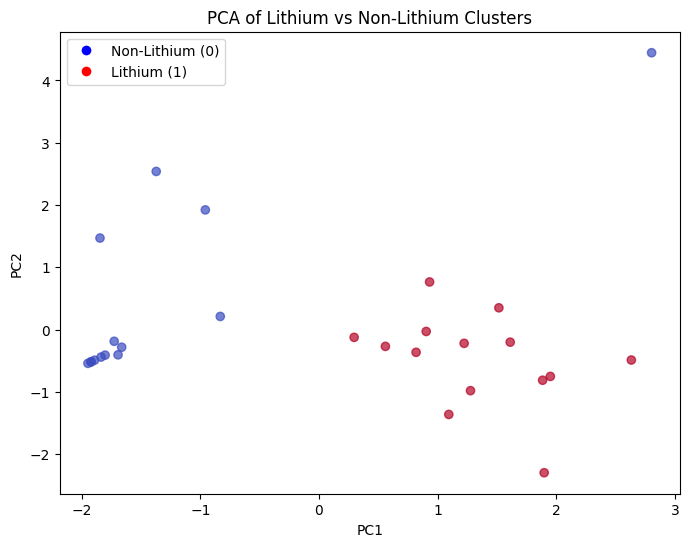

In [176]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_balanced, cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Lithium vs Non-Lithium Clusters")
plt.legend(handles=[
    plt.Line2D([0],[0], marker='o', color='w', label='Non-Lithium (0)', markerfacecolor='blue', markersize=8),
    plt.Line2D([0],[0], marker='o', color='w', label='Lithium (1)', markerfacecolor='red', markersize=8)
])
plt.show()

Since our PCA and leave-one-out also seem like the augmented model is picking up actual differences in the data when making predictions, we move forward with the model and see if it can generalize to predicting lithium presence in other states. We start with California and then we move on to Maine. We need to prep the California testing data before we can run the augmented model to make predictions on that testing data.

In [177]:

min_lat, max_lat = 32.534156, 42.009518   # southernmost to northernmost
min_lon, max_lon = -124.409591, -114.131211  # westernmost to easternmost
import geopandas as gpd


us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)


ca = us_states[us_states['NAME'] == "California"]


minerals = minerals.to_crs(ca.crs)


minerals_ca = minerals[minerals.within(ca.geometry.iloc[0])]

print(f"Original count: {len(minerals)}")
print(f"Points strictly INSIDE California: {len(minerals_ca)}")
print(minerals_ca.head())

Original count: 304632
Points strictly INSIDE California: 42720
        DEP_ID                    SITE_NAME       DEV_STAT  \
6705  10006806                Alhambra Mine  Past Producer   
6706  10006807                   Lost Cabin  Past Producer   
6707  10006808  Grovers Hot Springs Deposit  Past Producer   
6708  10006809                        Vance  Past Producer   
6709  10006810                Lady Franklin  Past Producer   

                                                    URL            CODE_LIST  \
6705  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU AG CU PB ZN W MO   
6706  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...          AU AG CU PB   
6707  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...               LST MG   
6708  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                   AU   
6709  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                AU AG   

                         geometry  longitude  latitude  
6705  POINT (-119.97211 3

In [178]:

minerals_ca_projected = minerals_ca.to_crs(epsg=3310)


minerals_ca_projected = minerals_ca_projected[
    ~minerals_ca_projected['DEV_STAT'].isin(['Unknown', 'Plant']) &
    ~(minerals_ca_projected['CODE_LIST'] == 'SDG')
]

print(f"Projected California dataset count: {len(minerals_ca_projected)}")
print(minerals_ca_projected.head())

Projected California dataset count: 33802
        DEP_ID                    SITE_NAME       DEV_STAT  \
6705  10006806                Alhambra Mine  Past Producer   
6706  10006807                   Lost Cabin  Past Producer   
6707  10006808  Grovers Hot Springs Deposit  Past Producer   
6708  10006809                        Vance  Past Producer   
6709  10006810                Lady Franklin  Past Producer   

                                                    URL            CODE_LIST  \
6705  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU AG CU PB ZN W MO   
6706  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...          AU AG CU PB   
6707  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...               LST MG   
6708  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                   AU   
6709  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                AU AG   

                         geometry  longitude  latitude  
6705   POINT (2422.484 79070.446) -119.97211  3

In [179]:

li_mines = minerals_ca_projected[
    minerals_ca_projected['CODE_LIST'].str.contains('LI', na=False)
]



In [180]:

non_li_mines = minerals_ca_projected[
    ~minerals_ca_projected['CODE_LIST'].str.contains('LI', na=False)
]

print(non_li_mines.head())

        DEP_ID                    SITE_NAME       DEV_STAT  \
6705  10006806                Alhambra Mine  Past Producer   
6706  10006807                   Lost Cabin  Past Producer   
6707  10006808  Grovers Hot Springs Deposit  Past Producer   
6708  10006809                        Vance  Past Producer   
6709  10006810                Lady Franklin  Past Producer   

                                                    URL            CODE_LIST  \
6705  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU AG CU PB ZN W MO   
6706  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...          AU AG CU PB   
6707  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...               LST MG   
6708  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                   AU   
6709  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...                AU AG   

                         geometry  longitude  latitude  
6705   POINT (2422.484 79070.446) -119.97211  38.72768  
6706  POINT (-1293.603 73975.956

We create the California KMeans clusters using the same techniques as above. We start with 20 and then decrease to 15 again.

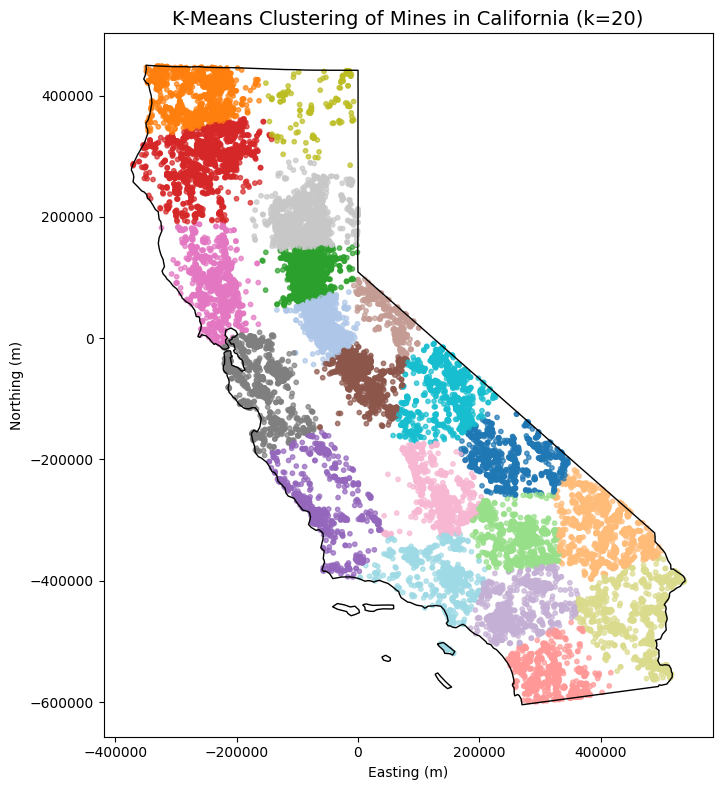

In [181]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_ca_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 20  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)

us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)
ca = us_states[us_states['NAME'] == "California"].to_crs(gdf.crs)


fig, ax = plt.subplots(figsize=(10, 8))

ca.boundary.plot(ax=ax, color='black', linewidth=1)


gdf.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7, legend=False)

ax.set_title(f"K-Means Clustering of Mines in California (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

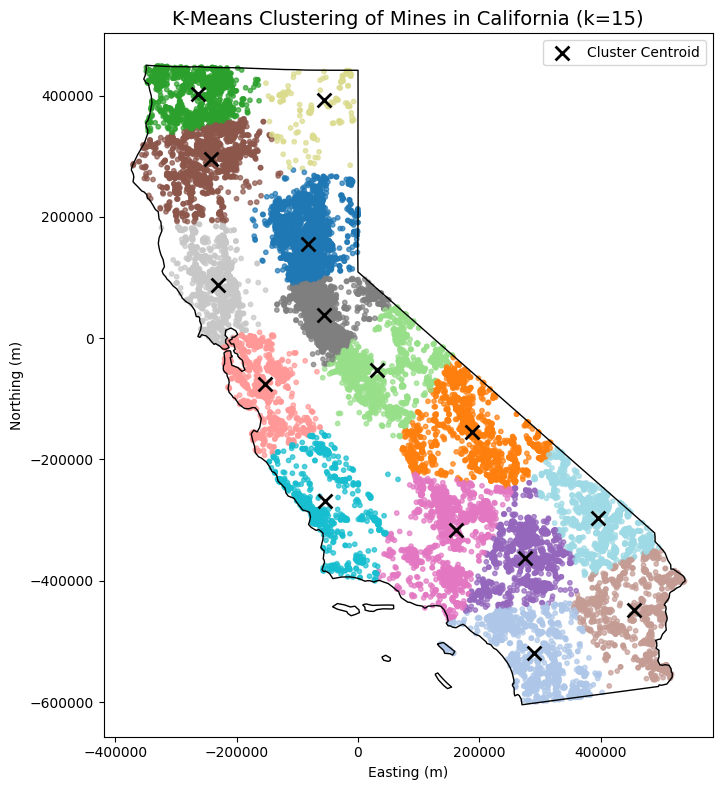

In [182]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_ca_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 15  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)


us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)
ca = us_states[us_states['NAME'] == "California"].to_crs(gdf.crs)


fig, ax = plt.subplots(figsize=(10, 8))


ca.boundary.plot(ax=ax, color='black', linewidth=1)

gdf.plot(ax=ax, column='cluster', cmap='tab20',
         markersize=10, alpha=0.7, legend=False)


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker='x', s=100, c='black', linewidths=2,
            label='Cluster Centroid')


plt.legend()

ax.set_title(f"K-Means Clustering of Mines in California (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [183]:

minerals_ca_projected['cluster'] = gdf['cluster'].values


print(minerals_ca_projected[['DEP_ID', 'SITE_NAME', 'cluster', 'CODE_LIST']].head())

        DEP_ID                    SITE_NAME  cluster            CODE_LIST
6705  10006806                Alhambra Mine       10  AU AG CU PB ZN W MO
6706  10006807                   Lost Cabin       10          AU AG CU PB
6707  10006808  Grovers Hot Springs Deposit       10               LST MG
6708  10006809                        Vance       10                   AU
6709  10006810                Lady Franklin       10                AU AG


In [184]:

cluster_targets_ca_clusters = (
    minerals_ca_projected
    .assign(LI_present=lambda df: df['CODE_LIST'].str.contains('LI', na=False).astype(int))
    .groupby('cluster')['LI_present']
    .max()
    .reset_index()
)

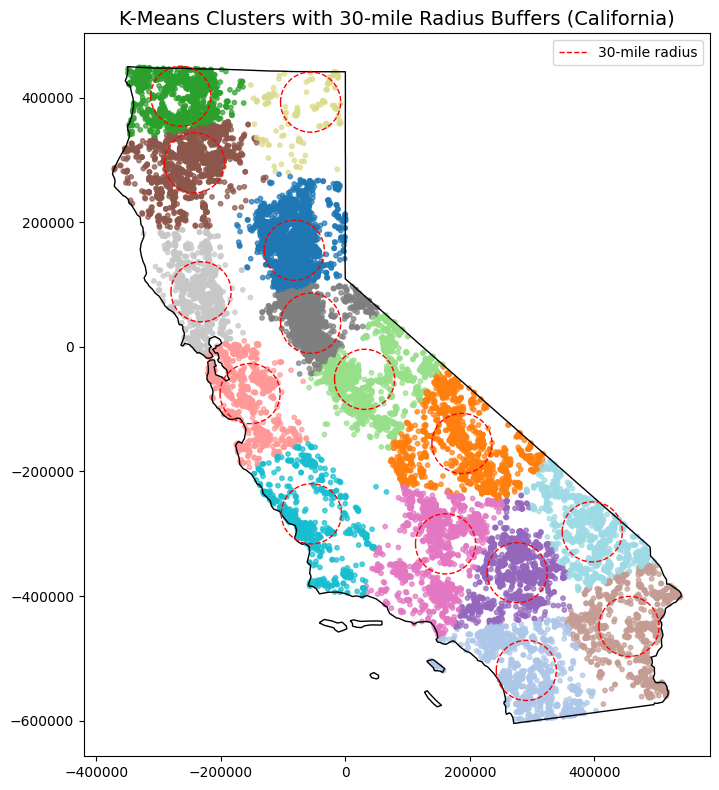

In [185]:

radius_meters = 30 * 1609.34


from shapely.geometry import Point
centroid_points = [Point(xy) for xy in centers]  
centroids_gdf = gpd.GeoDataFrame({'cluster': range(len(centers))},
                                 geometry=centroid_points,
                                 crs=minerals_ca_projected.crs)

buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


radius_meters = 30 * 1609.34
centroid_points = [Point(xy) for xy in centers]  
centroids_gdf = gpd.GeoDataFrame(
    {'cluster': range(len(centers))},
    geometry=centroid_points,
    crs=minerals_ca_projected.crs  
)

buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


df_exploded = df_exploded.to_crs(buffers_gdf.crs)

joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')

fig, ax = plt.subplots(figsize=(10, 8))


ca.boundary.plot(ax=ax, color='black', linewidth=1)


buffers_gdf.boundary.plot(ax=ax, color='red', linestyle='--', linewidth=1, label='30-mile radius')


minerals_ca_projected.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7)
plt.legend()
ax.set_title("K-Means Clusters with 30-mile Radius Buffers (California)", fontsize=14)
plt.tight_layout()
plt.show()

In [186]:
df = minerals_ca_projected[['cluster', 'CODE_LIST', 'geometry']].copy()
df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']
df['elements'] = df['CODE_LIST'].str.split(r'\s+')

df_exploded = df.explode('elements')
df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']
df_exploded = gpd.GeoDataFrame(df_exploded, geometry='geometry', crs=minerals_ca_projected.crs)



joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')

target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']
filtered = joined[joined['elements'].isin(target_elements)]


counts = (filtered.groupby(['cluster_right', 'elements'])
                    .size()
                    .reset_index(name='count'))

print(counts)

    cluster_right elements  count
0               0      QTZ      1
1               0       SN      1
2               1       BE      6
3               1      FLD     24
4               1      MIC      4
5               1      QTZ      8
6               1       SN      3
7               2       BE      1
8               4      FLD      2
9               4      MIC      2
10              4      QTZ      2
11              4       SN      1
12              5      QTZ      1
13              5       SN      1
14              6       BE      3
15              6      FLD      9
16              6      MIC      6
17              6      QTZ      3
18              7      MIC      1
19              7       SN      1
20              9       BE      1
21              9      FLD      3
22              9      QTZ      1
23              9       SN      3
24             10      QTZ      8
25             10       SN      2
26             11       SN      2
27             13      FLD      1
28            

In [187]:

totals = (
    joined.groupby('cluster_right')
          .size()
          .reset_index(name='total_number_of_minerals')
)


counts_with_totals = counts.merge(totals, on='cluster_right')


counts_with_totals['proportion'] = (
    counts_with_totals['count'] / counts_with_totals['total_number_of_minerals']
)

print(counts_with_totals)

    cluster_right elements  count  total_number_of_minerals  proportion
0               0      QTZ      1                      5003    0.000200
1               0       SN      1                      5003    0.000200
2               1       BE      6                       683    0.008785
3               1      FLD     24                       683    0.035139
4               1      MIC      4                       683    0.005857
5               1      QTZ      8                       683    0.011713
6               1       SN      3                       683    0.004392
7               2       BE      1                      1185    0.000844
8               4      FLD      2                      1632    0.001225
9               4      MIC      2                      1632    0.001225
10              4      QTZ      2                      1632    0.001225
11              4       SN      1                      1632    0.000613
12              5      QTZ      1                       725    0

In [188]:
print(joined.columns)

Index(['cluster_left', 'CODE_LIST', 'geometry', 'elements', 'index_right',
       'cluster_right'],
      dtype='object')


Now run predictions on California using the NC augmented model.

In [189]:

target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']

element_counts_ca = (
    joined[joined['elements'].isin(target_elements)]
    .groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='elements', values='count')
)


all_clusters_idx_ca = pd.Index(buffers_gdf['cluster'], name='cluster_right')
element_counts_ca_full = element_counts_ca.reindex(all_clusters_idx_ca).fillna(0)

totals_ca = (
    joined.groupby('cluster_right')
    .size()
    .reindex(all_clusters_idx_ca)
    .fillna(0)
    .rename('total')
)
element_props_ca = element_counts_ca_full.div(totals_ca, axis=0).fillna(0)


dev_counts_ca = (
    minerals_ca_projected
    .sjoin(buffers_gdf, how='inner', predicate='within')
    .groupby(['cluster_right', 'DEV_STAT'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='DEV_STAT', values='count')
)

dev_counts_ca_full = dev_counts_ca.reindex(all_clusters_idx_ca).fillna(0)
dev_counts_ca_full['num_places'] = dev_counts_ca_full.sum(axis=1)

X_ca = element_props_ca.merge(dev_counts_ca_full, left_index=True, right_index=True)


drop_cols = ['Past Producer', 'Producer', 'Occurrence', 'Prospect']
X_ca = X_ca.drop(columns=[c for c in drop_cols if c in X_ca.columns])


training_feature_columns = ['BE','CS','FLD','MIC','QTZ','SN','num_places']
X_ca = X_ca.reindex(columns=training_feature_columns, fill_value=0)


from sklearn.preprocessing import StandardScaler
scaler_ca = StandardScaler().fit(X_ca)
X_ca_scaled = scaler_ca.transform(X_ca)



y_ca_pred = combo_model.predict(X_ca_scaled)
y_ca_prob = combo_model.predict_proba(X_ca_scaled)[:, 1]



results_ca = pd.DataFrame({
    'cluster_right': X_ca.index,
    'predicted_label': y_ca_pred,
    'predicted_prob': y_ca_prob
})


results_ca = results_ca.merge(
    cluster_targets_ca_clusters,
    left_on='cluster_right',
    right_on='cluster',
    how='left'
)

print(results_ca)

    cluster_right  predicted_label  predicted_prob  cluster  LI_present
0               0                1        0.548433        0           0
1               1                1        0.999503        1           1
2               2                0        0.379891        2           1
3               3                0        0.380410        3           0
4               4                1        0.634974        4           0
5               5                1        0.998210        5           0
6               6                1        0.637389        6           1
7               7                0        0.380410        7           0
8               8                0        0.379891        8           1
9               9                1        0.999503        9           1
10             10                1        0.636586       10           1
11             11                1        0.820216       11           0
12             12                0        0.379891       12     

/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [190]:

y_true_ca = results_ca['LI_present'].fillna(0).astype(int)
y_pred_ca = results_ca['predicted_label']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:\n", confusion_matrix(y_true_ca, y_pred_ca))
print("\nClassification report:\n", classification_report(y_true_ca, y_pred_ca))

Confusion matrix:
 [[4 5]
 [2 4]]

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.44      0.67      0.53         6

    accuracy                           0.53        15
   macro avg       0.56      0.56      0.53        15
weighted avg       0.58      0.53      0.53        15



Now run on Maine data in a similar fashion

In [191]:

min_lat, max_lat = 42.977764, 47.459686   # southernmost to northernmost
min_lon, max_lon = -71.083924, -66.949895  # westernmost to easternmost

import geopandas as gpd


us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)


me = us_states[us_states['NAME'] == "Maine"]


minerals = minerals.to_crs(me.crs)


minerals_me = minerals[minerals.within(me.geometry.iloc[0])]

print(f"Original count: {len(minerals)}")
print(f"Points strictly INSIDE Maine: {len(minerals_me)}")
print(minerals_me.head())

Original count: 304632
Points strictly INSIDE Maine: 1655
        DEP_ID                                       SITE_NAME    DEV_STAT  \
8258  10008385                                Blue Hills Falls  Occurrence   
8259  10008386                    Candage Farm Prospect (1836)  Occurrence   
8260  10008387             Catherine Hill Molybdenite Prospect  Occurrence   
8261  10008388  Long Island Molybdenite Occurrence, East Shore  Occurrence   
8262  10008389   Pequoit; Sands; Duchesnehill Granite Quarries  Occurrence   

                                                    URL CODE_LIST  \
8258  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        MO   
8259  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      MO W   
8260  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        MO   
8261  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      MO W   
8262  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     MO ZR   

                        geometry  longitude  latitude  
82

In [192]:

minerals_me_projected = minerals_me.to_crs(epsg=32119)


minerals_me_projected = minerals_me_projected[
    ~minerals_me_projected['DEV_STAT'].isin(['Unknown', 'Plant']) &
    ~(minerals_me_projected['CODE_LIST'] == 'SDG')
]

print(f"Projected Maine dataset count: {len(minerals_me_projected)}")
print(minerals_me_projected.head())

Projected Maine dataset count: 1181
        DEP_ID                                       SITE_NAME    DEV_STAT  \
8258  10008385                                Blue Hills Falls  Occurrence   
8259  10008386                    Candage Farm Prospect (1836)  Occurrence   
8260  10008387             Catherine Hill Molybdenite Prospect  Occurrence   
8261  10008388  Long Island Molybdenite Occurrence, East Shore  Occurrence   
8262  10008389   Pequoit; Sands; Duchesnehill Granite Quarries  Occurrence   

                                                    URL CODE_LIST  \
8258  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        MO   
8259  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      MO W   
8260  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        MO   
8261  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      MO W   
8262  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     MO ZR   

                             geometry  longitude  latitude  
8258  POINT (145067

In [193]:

li_mines = minerals_me_projected[
    minerals_me_projected['CODE_LIST'].str.contains('LI', na=False)
]


non_li_mines = minerals_me_projected[
    ~minerals_me_projected['CODE_LIST'].str.contains('LI', na=False)
    ]

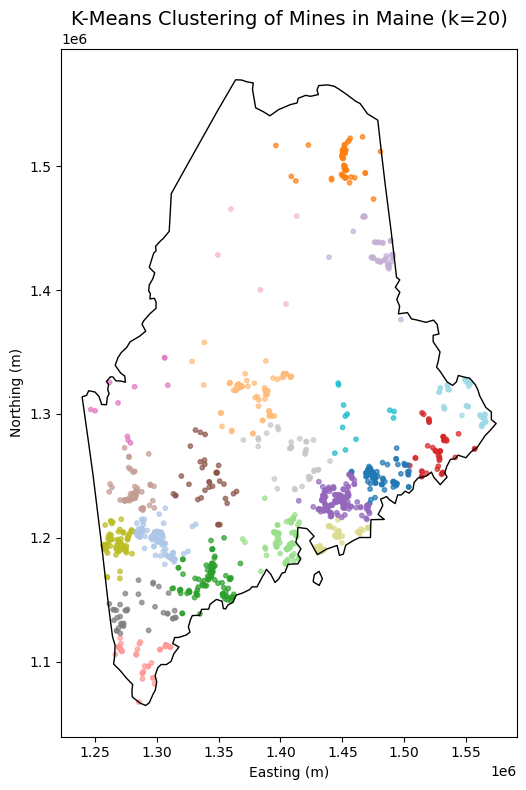

In [194]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_me_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 20  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)


us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)
me = us_states[us_states['NAME'] == "Maine"].to_crs(gdf.crs)
# --- STEP 4: Plot Maine basemap + clusters (no legend) ---
fig, ax = plt.subplots(figsize=(10, 8))

me.boundary.plot(ax=ax, color='black', linewidth=1)


gdf.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7, legend=False)

ax.set_title(f"K-Means Clustering of Mines in Maine (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

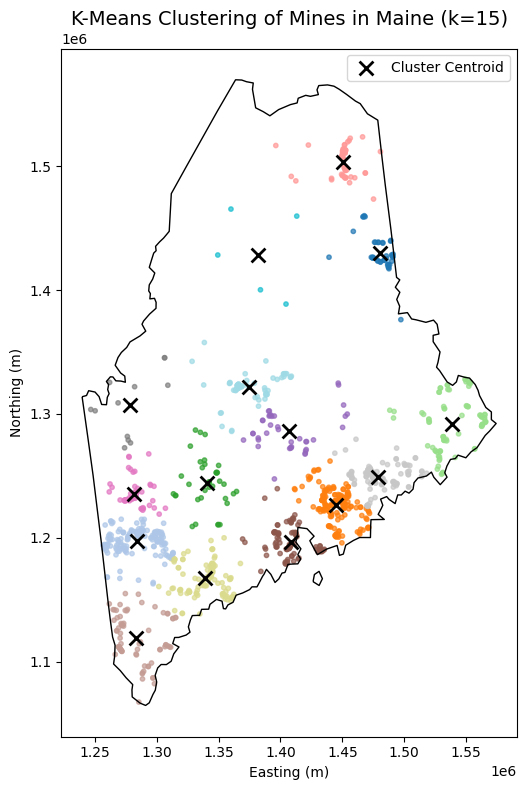

In [195]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


gdf = minerals_me_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


k = 15  
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)

us_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(us_url)
me = us_states[us_states['NAME'] == "Maine"].to_crs(gdf.crs)


fig, ax = plt.subplots(figsize=(10, 8))


me.boundary.plot(ax=ax, color='black', linewidth=1)


gdf.plot(ax=ax, column='cluster', cmap='tab20',
         markersize=10, alpha=0.7, legend=False)


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker='x', s=100, c='black', linewidths=2,
            label='Cluster Centroid')


plt.legend()


ax.set_title(f"K-Means Clustering of Mines in Maine (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [196]:

minerals_me_projected['cluster'] = gdf['cluster'].values


print(minerals_me_projected[['DEP_ID', 'SITE_NAME', 'cluster', 'CODE_LIST']].head())


cluster_targets_me_clusters = (
    minerals_me_projected
    .assign(LI_present=lambda df: df['CODE_LIST'].str.contains('LI', na=False).astype(int))
    .groupby('cluster')['LI_present']
    .max()
    .reset_index()
)

        DEP_ID                                       SITE_NAME  cluster  \
8258  10008385                                Blue Hills Falls        2   
8259  10008386                    Candage Farm Prospect (1836)        2   
8260  10008387             Catherine Hill Molybdenite Prospect       11   
8261  10008388  Long Island Molybdenite Occurrence, East Shore        2   
8262  10008389   Pequoit; Sands; Duchesnehill Granite Quarries        7   

     CODE_LIST  
8258        MO  
8259      MO W  
8260        MO  
8261      MO W  
8262     MO ZR  


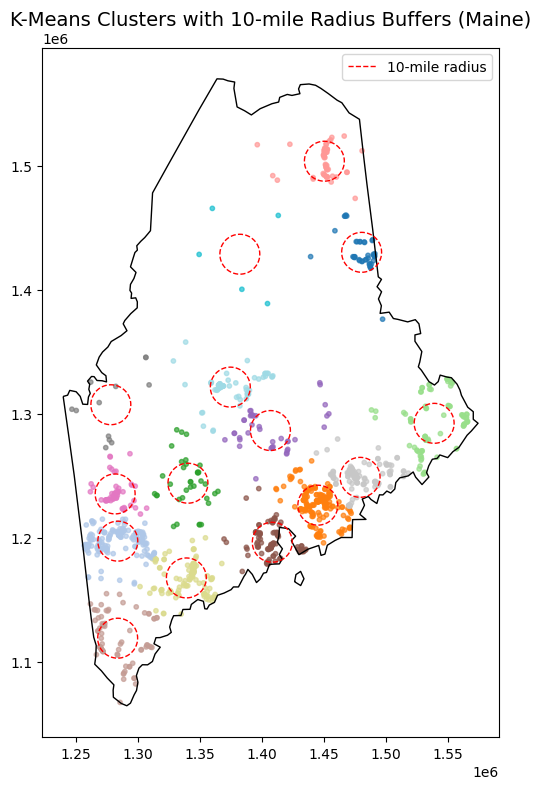

In [197]:

radius_meters = 10 * 1609.34

from shapely.geometry import Point


centroid_points = [Point(xy) for xy in centers]  
centroids_gdf = gpd.GeoDataFrame(
    {'cluster': range(len(centers))},
    geometry=centroid_points,
    crs=minerals_me_projected.crs  
)

buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


df_exploded = df_exploded.to_crs(buffers_gdf.crs)
joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')


fig, ax = plt.subplots(figsize=(10, 8))

me.boundary.plot(ax=ax, color='black', linewidth=1)


buffers_gdf.boundary.plot(ax=ax, color='red', linestyle='--', linewidth=1, label='10-mile radius')


minerals_me_projected.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7)

plt.legend()
ax.set_title("K-Means Clusters with 10-mile Radius Buffers (Maine)", fontsize=14)
plt.tight_layout()
plt.show()

In [198]:

df = minerals_me_projected[['cluster', 'CODE_LIST', 'geometry']].copy()
df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']
df['elements'] = df['CODE_LIST'].str.split(r'\s+')


df_exploded = df.explode('elements')
df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']
df_exploded = gpd.GeoDataFrame(df_exploded, geometry='geometry', crs=minerals_me_projected.crs)


joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')


target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']
filtered = joined[joined['elements'].isin(target_elements)]


counts = (
    filtered.groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
)

print(counts)

    cluster_right elements  count
0               1       BE     22
1               1       CS      2
2               1      FLD     36
3               1      MIC     26
4               1      QTZ      5
5               1       SN      3
6               2       SN      3
7               3      FLD      1
8               3      MIC      1
9               7      FLD      3
10              7      MIC      1
11              8       BE      1
12              8      FLD      2
13              8      MIC      1
14              8       SN      2
15              9       BE     22
16              9       CS      3
17              9      FLD     15
18              9      MIC     13
19              9      QTZ      1
20              9       SN      5
21             12       BE     13
22             12      FLD     49
23             12      MIC     22


In [199]:
totals = (
    joined.groupby('cluster_right')
          .size()
          .reset_index(name='total_number_of_minerals')
)


counts_with_totals = counts.merge(totals, on='cluster_right')


counts_with_totals['proportion'] = (
    counts_with_totals['count'] / counts_with_totals['total_number_of_minerals']
)

print(counts_with_totals)

    cluster_right elements  count  total_number_of_minerals  proportion
0               1       BE     22                       165    0.133333
1               1       CS      2                       165    0.012121
2               1      FLD     36                       165    0.218182
3               1      MIC     26                       165    0.157576
4               1      QTZ      5                       165    0.030303
5               1       SN      3                       165    0.018182
6               2       SN      3                       262    0.011450
7               3      FLD      1                        20    0.050000
8               3      MIC      1                        20    0.050000
9               7      FLD      3                        90    0.033333
10              7      MIC      1                        90    0.011111
11              8       BE      1                        47    0.021277
12              8      FLD      2                        47    0

In [200]:

target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']

element_counts_me = (
    joined[joined['elements'].isin(target_elements)]
    .groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='elements', values='count')
)


all_clusters_idx_me = pd.Index(buffers_gdf['cluster'], name='cluster_right')
element_counts_me_full = element_counts_me.reindex(all_clusters_idx_me).fillna(0)

totals_me = (
    joined.groupby('cluster_right')
    .size()
    .reindex(all_clusters_idx_me)
    .fillna(0)
    .rename('total')
)
element_props_me = element_counts_me_full.div(totals_me, axis=0).fillna(0)


dev_counts_me = (
    minerals_me_projected
    .sjoin(buffers_gdf, how='inner', predicate='within')
    .groupby(['cluster_right', 'DEV_STAT'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='DEV_STAT', values='count')
)
dev_counts_me_full = dev_counts_me.reindex(all_clusters_idx_me).fillna(0)
dev_counts_me_full['num_places'] = dev_counts_me_full.sum(axis=1)


X_me = element_props_me.merge(dev_counts_me_full, left_index=True, right_index=True)


drop_cols = ['Past Producer', 'Producer', 'Occurrence', 'Prospect']
X_me = X_me.drop(columns=[c for c in drop_cols if c in X_me.columns])


training_feature_columns = ['BE','CS','FLD','MIC','QTZ','SN','num_places']
X_me = X_me.reindex(columns=training_feature_columns, fill_value=0)

from sklearn.preprocessing import StandardScaler
scaler_me = StandardScaler().fit(X_me)
X_me_scaled = scaler_me.transform(X_me)


y_me_pred = combo_model.predict(X_me_scaled)
y_me_prob = combo_model.predict_proba(X_me_scaled)[:, 1]


results_me = pd.DataFrame({
    'cluster_right': X_me.index,
    'predicted_label': y_me_pred,
    'predicted_prob': y_me_prob
})


results_me = results_me.merge(
    cluster_targets_me_clusters,
    left_on='cluster_right',
    right_on='cluster',
    how='left'
)

print(results_me)

    cluster_right  predicted_label  predicted_prob  cluster  LI_present
0               0                0        0.262314        0           0
1               1                1        0.999977        1           1
2               2                1        0.862990        2           0
3               3                1        0.548734        3           0
4               4                0        0.262314        4           0
5               5                0        0.262314        5           0
6               6                0        0.262314        6           0
7               7                1        0.549253        7           1
8               8                1        0.911596        8           0
9               9                1        0.999977        9           1
10             10                0        0.262314       10           0
11             11                0        0.262833       11           0
12             12                1        0.549253       12     

/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [201]:

y_true_me = results_me['LI_present'].fillna(0).astype(int)
y_pred_me = results_me['predicted_label']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix (Maine):\n", confusion_matrix(y_true_me, y_pred_me))
print("\nClassification report (Maine):\n", classification_report(y_true_me, y_pred_me))

Confusion matrix (Maine):
 [[8 3]
 [0 4]]

Classification report (Maine):
               precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.57      1.00      0.73         4

    accuracy                           0.80        15
   macro avg       0.79      0.86      0.78        15
weighted avg       0.89      0.80      0.81        15



Now since our augmented model has thus far struggled to generalize outside of North Carolina, we devise 3 alternative models to see if any of those options are more feasible for prediction. The first model involves training on combined North Carolina and California data and then predicting Maine lithium presence.

In [202]:

cluster_targets_nc_clusters = (
    minerals_nc_projected
    .assign(LI_present=lambda df: df['CODE_LIST'].str.contains('LI', na=False).astype(int))
    .groupby('cluster')['LI_present']
    .max()
    .reset_index()
)

import geopandas as gpd


radius_meters = 10 * 1609.34


centroids_gdf_nc = (
    minerals_nc_projected
    .dissolve(by='cluster')             
    .centroid                           
    .to_frame(name='geometry')
    .reset_index()
)
centroids_gdf_nc = gpd.GeoDataFrame(centroids_gdf_nc, geometry='geometry', crs=minerals_nc_projected.crs)

buffers_gdf_nc = centroids_gdf_nc.copy()
buffers_gdf_nc['geometry'] = buffers_gdf_nc.buffer(radius_meters)


target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']
df_nc = minerals_nc_projected[['cluster', 'CODE_LIST', 'geometry']].copy()
df_nc = df_nc.dropna(subset=['CODE_LIST'])
df_nc = df_nc[df_nc['CODE_LIST'].str.strip() != '']
df_nc['elements'] = df_nc['CODE_LIST'].str.split(r'\s+')

df_nc_exploded = df_nc.explode('elements')
df_nc_exploded['elements'] = df_nc_exploded['elements'].str.strip()
df_nc_exploded = df_nc_exploded[df_nc_exploded['elements'] != '']
df_nc_exploded = gpd.GeoDataFrame(df_nc_exploded, geometry='geometry', crs=minerals_nc_projected.crs)

joined_nc = gpd.sjoin(df_nc_exploded, buffers_gdf_nc, how='inner', predicate='within')

element_counts_nc = (
    joined_nc[joined_nc['elements'].isin(target_elements)]
    .groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='elements', values='count')
)

all_clusters_idx_nc = pd.Index(buffers_gdf_nc['cluster'], name='cluster_right')
element_counts_nc_full = element_counts_nc.reindex(all_clusters_idx_nc).fillna(0)
totals_nc = (
    joined_nc.groupby('cluster_right')
    .size()
    .reindex(all_clusters_idx_nc)
    .fillna(0)
    .rename('total')
)
element_props_nc = element_counts_nc_full.div(totals_nc, axis=0).fillna(0)


dev_counts_nc = (
    minerals_nc_projected
    .sjoin(buffers_gdf_nc, how='inner', predicate='within')
    .groupby(['cluster_right', 'DEV_STAT'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='DEV_STAT', values='count')
)
dev_counts_nc_full = dev_counts_nc.reindex(all_clusters_idx_nc).fillna(0)
dev_counts_nc_full['num_places'] = dev_counts_nc_full.sum(axis=1)

X_nc = element_props_nc.merge(dev_counts_nc_full, left_index=True, right_index=True)

drop_cols = ['Past Producer', 'Producer', 'Occurrence', 'Prospect']
X_nc = X_nc.drop(columns=[c for c in drop_cols if c in X_nc.columns])

training_feature_columns = ['BE','CS','FLD','MIC','QTZ','SN','num_places']
X_nc = X_nc.reindex(columns=training_feature_columns, fill_value=0)

y_nc = cluster_targets_nc_clusters['LI_present'].astype(int)

In [203]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # or your combo_model


y_ca = cluster_targets_ca_clusters['LI_present'].astype(int)


X_train = pd.concat([X_nc, X_ca], axis=0)
y_train = pd.concat([y_nc, y_ca], axis=0)


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)


model = RandomForestClassifier(random_state=0, n_estimators=200)
model.fit(X_train_scaled, y_train)

X_me_scaled = scaler.transform(X_me)


y_me_pred = model.predict(X_me_scaled)
y_me_prob = model.predict_proba(X_me_scaled)[:, 1]

results_me = pd.DataFrame({
    'cluster_right': X_me.index,
    'predicted_label': y_me_pred,
    'predicted_prob': y_me_prob
})


results_me = results_me.merge(
    cluster_targets_me_clusters,
    left_on='cluster_right',
    right_on='cluster',
    how='left'
)
print(results_me)


from sklearn.metrics import confusion_matrix, classification_report

y_true_me = results_me['LI_present'].fillna(0).astype(int)
y_pred_me = results_me['predicted_label']

print("Confusion matrix (Maine):\n", confusion_matrix(y_true_me, y_pred_me))
print("\nClassification report (Maine):\n", classification_report(y_true_me, y_pred_me))

    cluster_right  predicted_label  predicted_prob  cluster  LI_present
0               0                0           0.000        0           0
1               1                1           0.550        1           1
2               2                0           0.210        2           0
3               3                0           0.060        3           0
4               4                0           0.000        4           0
5               5                0           0.000        5           0
6               6                0           0.000        6           0
7               7                0           0.075        7           1
8               8                0           0.400        8           0
9               9                1           0.520        9           1
10             10                0           0.000       10           0
11             11                0           0.000       11           0
12             12                0           0.180       12     

Training the model on combined data from NC and CA made it more generalizable to Maine, and in fact our accuracy looks quite nice. However, we still want to proceed with making two other alternative models to see if we can improve any more. If we cannot make any further improvements, we will adopt the combined NC/CA trained model as our final model.

As our second alternative model, we create an additional predictor that is the maximum euclidean distance between two points in the cluster. We start by creating an updated north carolina model (by incorporating this new predictor into our augmented model) and then we'll run that on california data again to see if we predict any better than before. 

In [204]:
from scipy.spatial import distance_matrix

buffers_gdf['centroid'] = buffers_gdf.geometry.centroid


coords_by_cluster = (
    buffers_gdf.groupby('cluster')['centroid']
    .apply(lambda g: [(pt.x, pt.y) for pt in g])
)


max_distances = {}
for cluster, coords in coords_by_cluster.items():
    if len(coords) > 1:
        dist_mat = distance_matrix(coords, coords)
        max_distances[cluster] = dist_mat.max()
    else:
        max_distances[cluster] = 0.0
max_distances = pd.Series(max_distances, name='max_distance')

X = X.merge(max_distances, left_index=True, right_index=True)

X_li = X[y == 1]
X_non_li = X[y == 0]

n_li = len(X_li)
n_non_li = len(X_non_li)
num_new_samples = max(0, n_non_li - n_li)


X_augmented_li = augment_with_noise(X_li, num_new_samples // max(1, len(X_li)))
y_augmented_li = pd.Series([1] * len(X_augmented_li), name='LI_present')


X_balanced = pd.concat([X, X_augmented_li], ignore_index=True)
y_balanced = pd.concat([y, y_augmented_li], ignore_index=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score

gb_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

updated_combo_model = BaggingClassifier(
    estimator=gb_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(updated_combo_model, df_scaled, y_balanced, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())
print("Balanced class counts:\n", y_balanced.value_counts())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0
Balanced class counts:
 LI_present
0    14
1    14
Name: count, dtype: int64


In [205]:

updated_combo_model.fit(df_scaled, y_balanced)


from sklearn.metrics import confusion_matrix, classification_report

y_pred = updated_combo_model.predict(df_scaled)

print("Confusion matrix:\n", confusion_matrix(y_balanced, y_pred))
print("\nClassification report:\n", classification_report(y_balanced, y_pred))

Confusion matrix:
 [[14  0]
 [ 0 14]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



Now that we have trained the model and made sure it works, we want to run this model on California to test predictive power.

In [206]:

training_feature_columns = ['BE','CS','FLD','MIC','QTZ','SN','num_places','max_distance']
X_ca = X_ca.reindex(columns=training_feature_columns, fill_value=0)


X_ca_scaled = scaler.transform(X_ca)


y_ca_pred = updated_combo_model.predict(X_ca_scaled)
y_ca_prob = updated_combo_model.predict_proba(X_ca_scaled)[:, 1]


results_ca = pd.DataFrame({
    'cluster_right': X_ca.index,
    'predicted_label': y_ca_pred,
    'predicted_prob': y_ca_prob
})


results_ca = results_ca.merge(
    cluster_targets_ca_clusters,
    left_on='cluster_right',
    right_on='cluster',
    how='left'
)
print(results_ca)


y_true_ca = results_ca['LI_present'].fillna(0).astype(int)
y_pred_ca = results_ca['predicted_label']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:\n", confusion_matrix(y_true_ca, y_pred_ca))
print("\nClassification report:\n", classification_report(y_true_ca, y_pred_ca, digits=3, zero_division=0))

    cluster_right  predicted_label  predicted_prob  cluster  LI_present
0               0                0        0.006768        0           0
1               1                0        0.011228        1           1
2               2                0        0.006768        2           1
3               3                0        0.006768        3           0
4               4                0        0.006768        4           0
5               5                0        0.006768        5           0
6               6                0        0.006768        6           1
7               7                0        0.006768        7           0
8               8                0        0.006768        8           1
9               9                0        0.006768        9           1
10             10                0        0.006768       10           1
11             11                0        0.006768       11           0
12             12                0        0.000022       12     

/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


This is worse than our first alternative model since never predicted that a cluster contains lithium, so the new predictor did not help our model to generalize to California data. Thus we move on to our third alternative model, keeping in mind that our first alternative model was the best so far.

For the third alternative model, I will return to my original augmented NC model (not the one with the newest predictor) and try to optimize the hyperparameters.

In [207]:
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score


X_balanced = pd.concat([X, X_augmented_li], ignore_index=True)
y_balanced = pd.concat([y, y_augmented_li], ignore_index=True)


if 'max_distance' in X_balanced.columns:
    X_balanced = X_balanced.drop(columns=['max_distance'])


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
df_scaled = pd.DataFrame(X_scaled, columns=X_balanced.columns)


gb_base = GradientBoostingClassifier(
    n_estimators=100,       # optimized
    learning_rate=0.05,     # optimized
    max_depth=3,            # optimized
    random_state=42
)


last_attempt_combo_model = BaggingClassifier(
    estimator=gb_base,
    n_estimators=10,        # optimized
    max_samples=1.0,        # optimized
    max_features=1.0,       # keep full feature set
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(last_attempt_combo_model, df_scaled, y_balanced, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())


print("Balanced class counts:\n", y_balanced.value_counts())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0
Balanced class counts:
 LI_present
0    14
1    14
Name: count, dtype: int64


In [208]:

last_attempt_combo_model.fit(df_scaled, y_balanced)


from sklearn.metrics import confusion_matrix, classification_report

y_pred = last_attempt_combo_model.predict(df_scaled)

print("Confusion matrix:\n", confusion_matrix(y_balanced, y_pred))
print("\nClassification report:\n", classification_report(y_balanced, y_pred))

Confusion matrix:
 [[14  0]
 [ 0 14]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



Now I will run this third alternative model on California to see if we can do any better.

In [209]:
training_feature_columns = ['BE','CS','FLD','MIC','QTZ','SN','num_places']
X_ca = X_ca.reindex(columns=training_feature_columns, fill_value=0)


X_ca_scaled = scaler.transform(X_ca)


y_ca_pred = last_attempt_combo_model.predict(X_ca_scaled)
y_ca_prob = last_attempt_combo_model.predict_proba(X_ca_scaled)[:, 1]


results_ca = pd.DataFrame({
    'cluster_right': X_ca.index,
    'predicted_label': y_ca_pred,
    'predicted_prob': y_ca_prob
})


results_ca = results_ca.merge(
    cluster_targets_ca_clusters,
    left_on='cluster_right',
    right_on='cluster',
    how='left'
)
print(results_ca)


y_true_ca = results_ca['LI_present'].fillna(0).astype(int)
y_pred_ca = results_ca['predicted_label']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix:\n", confusion_matrix(y_true_ca, y_pred_ca))
print("\nClassification report:\n", classification_report(y_true_ca, y_pred_ca, digits=3, zero_division=0))

    cluster_right  predicted_label  predicted_prob  cluster  LI_present
0               0                0        0.003354        0           0
1               1                0        0.041397        1           1
2               2                0        0.003354        2           1
3               3                0        0.003354        3           0
4               4                0        0.003354        4           0
5               5                0        0.003354        5           0
6               6                0        0.003354        6           1
7               7                0        0.003354        7           0
8               8                0        0.003354        8           1
9               9                0        0.003354        9           1
10             10                0        0.003354       10           1
11             11                0        0.003354       11           0
12             12                0        0.003354       12     

/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/Users/karasdukelaptop/Desktop/mineral_indicators_lithium/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


This new model is slightly better now that we have optimized hyperparameters, but we still struggle to generalize to California data from North Carolina. We do have higher accuracy and precision than before but our recall is worse for the true lithium-containing clusters.

Since the third alternative still wasn't as good as the first alternative model, we say that our final, most effective model was the first alternative model that was trained on a combination of NC and CA data to predict lithium presence in Maine. 